In [ ]:
!pip install statsmodels
!pip install seaborn


Differential Expression Results:
          Gene   Log2_FC  Fold_Change       P-value  Adj_P-value
0  100287102.0 -0.286495     0.819892  2.170580e-01          NaN
1     653635.0  0.109516     1.078866  6.847327e-01          NaN
2  102466751.0 -0.022197     0.984732  9.519596e-01          NaN
3  107985730.0  0.584963     1.500000  7.204343e-31          NaN
4  100302278.0  0.000000     1.000000           NaN          NaN


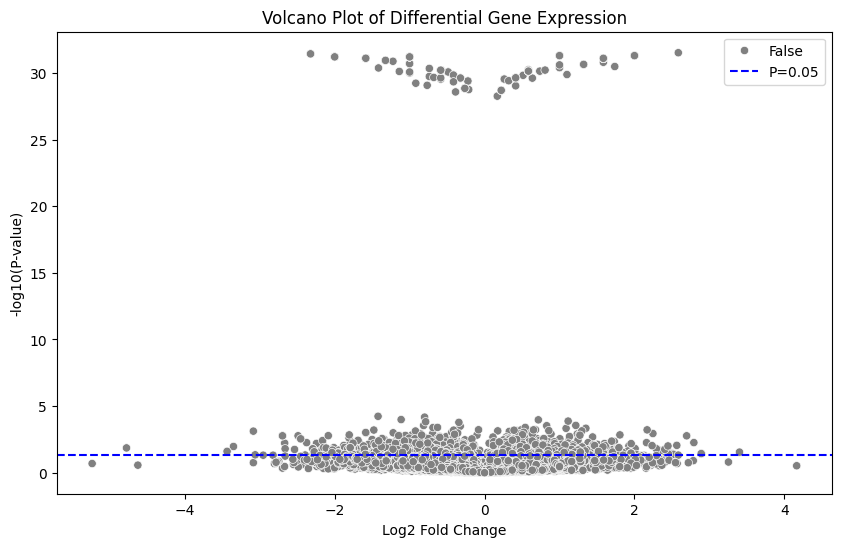

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (already downloaded)
df = pd.read_csv("RNA_SEQ.tsv", sep="\t", index_col=0)

# Select 4 example samples
selected_samples = ['GSM4656348', 'GSM4656349', 'GSM4656350', 'GSM4656351']
df = df[selected_samples].copy()

# Add gene names back as a column
df = df.reset_index().rename(columns={'index': 'GeneID'})

# Rename for clarity
df.columns = ['Gene', 'Control_1', 'Control_2', 'Treatment_1', 'Treatment_2']

# Define conditions (4 samples: 2 control, 2 treatment)
conditions = ['Control', 'Control', 'Treatment', 'Treatment']

# Log2 transform to stabilize variance (skip "Gene" column)
# --- CORRECTED BLOCK ---
# Calculate the log-transformed data first
log_data = np.log2(df.iloc[:, 1:] + 1)
# Create the new DataFrame by combining the 'Gene' column with the new log_data
df_log = pd.concat([df['Gene'], log_data], axis=1)
# --- END CORRECTION ---

# Differential Expression Analysis
results = []

for i, row in df_log.iterrows():
    gene = row['Gene']
    # Ensure y is float for the model
    y = row[['Control_1', 'Control_2', 'Treatment_1', 'Treatment_2']].values.astype(float)
    
    # Independent variable (0 for control, 1 for treatment)
    X = pd.get_dummies(conditions, drop_first=True).astype(float)
    X = sm.add_constant(X)  # add intercept
    
    # Fit OLS model
    model = sm.OLS(y, X).fit()
    
    # Extract stats
    log2_fc = model.params.iloc[1]
    fold_change = 2 ** log2_fc
    p_value = model.pvalues.iloc[1]
    
    results.append([gene, log2_fc, fold_change, p_value])

# Store results
results_df = pd.DataFrame(results, columns=['Gene', 'Log2_FC', 'Fold_Change', 'P-value'])

# Adjust p-values (FDR)
results_df['Adj_P-value'] = multipletests(results_df['P-value'], method='fdr_bh')[1]

print("\nDifferential Expression Results:")
print(results_df.head())

# Volcano plot

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df,
    x='Log2_FC',
    y=-np.log10(results_df['P-value']),
    hue=results_df['Adj_P-value'] < 0.05,
    palette={True: "red", False: "grey"}
)
plt.axhline(y=-np.log10(0.05), color='blue', linestyle='--', label='P=0.05')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(P-value)')
plt.title('Volcano Plot of Differential Gene Expression')
plt.legend()
plt.show()